# Chess CNN - Codificación Visual Temporal v3.0

Esta implementación prioriza la **interpretabilidad visual** para CNNs, permitiendo que
la red reconozca piezas visualmente mientras codifica información temporal mediante
intensidad de color.

## Arquitectura conceptual:

```
PGN → 8 SVGs (mov 23→15) → 8 PNGs → Aplicar intensidad temporal → Imagen final
```

### Orden temporal INVERSO:
- **Posición 0**: Movimiento MÁS RECIENTE (mov 23) → Intensidad MÁXIMA (brillante)
- **Posición 7**: Movimiento MÁS ANTIGUO (mov 15) → Intensidad MÍNIMA (oscuro)

### Codificación por intensidad:
- Movimiento reciente: Multiplicador 1.0 (brillo completo)
- Movimiento antiguo: Multiplicador 0.3 (oscurecido)
- Gradiente suave entre ambos extremos

### Espacio de metadatos:
Se reserva una banda lateral o canal alpha para codificar:
- Posibilidad de enroque (blancas/negras, lado rey/dama)
- Rey en jaque (blancas/negras)
- Turno actual
- Número de movimiento

## Compresión controlada:
- Factor 1: Sin compresión (máxima calidad visual)
- Factor 2: Compresión 2x (balance)
- Factor 4: Compresión 4x (eficiencia)
- Factor 8: Compresión 8x (mínima calidad aceptable)

In [6]:
import chess
import chess.pgn
import chess.svg
import numpy as np
import cv2
from typing import List, Tuple, Dict, Optional
from io import StringIO, BytesIO
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [10]:
# Configuración de parámetros
START_MOVE: int = 15  # Movimiento inicial (más antiguo)
END_MOVE: int = 23    # Movimiento final (más reciente)

# Factor de compresión: divisor del tamaño original
# Factor 1 = sin compresión (máxima calidad visual)
# Factor 2 = compresión 2x (tamaño/2 en cada dimensión)
# Factor 4 = compresión 4x (tamaño/4 en cada dimensión)
# Factor 8 = compresión 8x (tamaño/8 en cada dimensión)
COMPRESSION_FACTOR: int = 2

# Tamaño del tablero renderizado (antes de compresión)
# chess.svg.board genera 390x390 por defecto, usamos 400 para múltiplos limpios
BOARD_SIZE_PIXELS: int = 400

# Rango de intensidad temporal
# Movimiento más antiguo tendrá MIN_INTENSITY
# Movimiento más reciente tendrá MAX_INTENSITY (1.0)
MIN_INTENSITY: float = 0.3  # 30% de brillo para jugadas antiguas
MAX_INTENSITY: float = 1.0  # 100% de brillo para jugadas recientes

# Ancho de la banda de metadata (en pixels)
METADATA_BAND_WIDTH: int = 40

# Ruta al dataset de PGN
DATASET_PATH: Path = Path('../dataset')
pgn_path = DATASET_PATH / "chessgame0001.pgn"
# PGN import
with open(pgn_path, encoding="utf-8") as pgn:
    game = chess.pgn.read_game(pgn)
    if game is None:
        raise ValueError(f'No se pudo leer el PGN en {pgn_path}')
    # Exportar Game a string PGN para el resto del pipeline
    exporter = chess.pgn.StringExporter(headers=True, variations=False, comments=False)
    PGN_TEXT = game.accept(exporter)

In [11]:
def board_to_png_array(board: chess.Board, size: int = 400) -> np.ndarray:
    """Convierte un tablero de ajedrez a array numpy RGB desde SVG.
    
    Genera SVG sin coordenadas y lo convierte a imagen PNG RGB para
    que las piezas sean visualmente reconocibles por una CNN.
    
    Parameters
    ----------
    board : chess.Board
        Tablero de ajedrez en estado específico.
    size : int, optional
        Tamaño en pixels del tablero cuadrado (default: 400).
    
    Returns
    -------
    np.ndarray
        Array RGB de la imagen del tablero sin leyenda.
        Shape: (size, size, 3), dtype: uint8
    
    Raises
    ------
    TypeError
        [CHESS_CNN] board debe ser una instancia de chess.Board
    ValueError
        [CHESS_CNN] size debe ser positivo
    ImportError
        [CHESS_CNN] cairosvg no disponible para conversión SVG→PNG
    """
    if not isinstance(board, chess.Board):
        raise TypeError('[CHESS_CNN] board debe ser una instancia de chess.Board')
    
    if size <= 0:
        raise ValueError(f'[CHESS_CNN] size debe ser positivo, recibido: {size}')
    
    # Generar SVG sin coordenadas (sin leyenda a,b,c...)
    svg_data = chess.svg.board(board, size=size, coordinates=False)
    
    # Convertir SVG a PNG
    try:
        import cairosvg
        png_data = cairosvg.svg2png(bytestring=svg_data.encode('utf-8'))
        
        # Cargar PNG como imagen PIL y convertir a numpy
        from PIL import Image
        image = Image.open(BytesIO(png_data)).convert('RGB')
        img_array = np.array(image, dtype=np.uint8)
        
    except ImportError:
        raise ImportError('[CHESS_CNN] cairosvg no disponible. Instalar con: pip install cairosvg')
    
    # Redimensionar si es necesario para asegurar dimensiones exactas
    if img_array.shape[:2] != (size, size):
        img_array = cv2.resize(img_array, (size, size), interpolation=cv2.INTER_AREA)
    
    return img_array

In [12]:
def extract_game_state_metadata(board: chess.Board) -> Dict[str, bool]:
    """Extrae metadata de estado del juego.
    
    Información sobre el estado legal del juego que puede ser útil
    para la CNN (enroques disponibles, jaque, etc.).
    
    Parameters
    ----------
    board : chess.Board
        Tablero de ajedrez.
    
    Returns
    -------
    Dict[str, bool]
        Diccionario con flags de estado:
        - 'white_kingside_castle': Blancas pueden enrocar corto
        - 'white_queenside_castle': Blancas pueden enrocar largo
        - 'black_kingside_castle': Negras pueden enrocar corto
        - 'black_queenside_castle': Negras pueden enrocar largo
        - 'white_in_check': Rey blanco en jaque
        - 'black_in_check': Rey negro en jaque
        - 'white_to_move': Turno de blancas
    
    Raises
    ------
    TypeError
        [CHESS_CNN] board debe ser una instancia de chess.Board
    """
    if not isinstance(board, chess.Board):
        raise TypeError('[CHESS_CNN] board debe ser una instancia de chess.Board')
    
    metadata = {
        'white_kingside_castle': board.has_kingside_castling_rights(chess.WHITE),
        'white_queenside_castle': board.has_queenside_castling_rights(chess.WHITE),
        'black_kingside_castle': board.has_kingside_castling_rights(chess.BLACK),
        'black_queenside_castle': board.has_queenside_castling_rights(chess.BLACK),
        'white_in_check': board.is_check() and board.turn == chess.WHITE,
        'black_in_check': board.is_check() and board.turn == chess.BLACK,
        'white_to_move': board.turn == chess.WHITE
    }
    
    return metadata

In [13]:
def extract_board_sequence(pgn_text: str, start_move: int, end_move: int,
                          board_size: int = 400) -> List[Dict]:
    """Extrae secuencia de tableros desde un PGN.
    
    Extrae posiciones desde start_move hasta end_move (inclusive)
    en ORDEN INVERSO (más reciente primero).
    
    Parameters
    ----------
    pgn_text : str
        Texto PGN de la partida.
    start_move : int
        Número del primer movimiento (más antiguo) (1-indexed).
    end_move : int
        Número del último movimiento (más reciente) (1-indexed).
    board_size : int, optional
        Tamaño de la imagen del tablero (default: 400).
    
    Returns
    -------
    List[Dict]
        Lista de diccionarios EN ORDEN INVERSO (reciente→antiguo):
        - 'board_image': Array RGB del tablero (size, size, 3)
        - 'move_number': Número del movimiento
        - 'metadata': Diccionario de estado del juego
        - 'temporal_index': Índice temporal (0=más reciente, N-1=más antiguo)
    
    Raises
    ------
    ValueError
        [CHESS_CNN] PGN inválido
        [CHESS_CNN] start_move debe ser menor o igual a end_move
        [CHESS_CNN] No hay suficientes movimientos en la partida
    """
    if start_move > end_move:
        raise ValueError('[CHESS_CNN] start_move debe ser menor o igual a end_move')
    
    pgn = chess.pgn.read_game(StringIO(pgn_text))
    if pgn is None:
        raise ValueError('[CHESS_CNN] PGN inválido')
    
    board = pgn.board()
    sequence = []  # Temporalmente en orden normal
    move_count = 0
    
    for move in pgn.mainline_moves():
        move_count += 1
        board.push(move)
        
        if start_move <= move_count <= end_move:
            # Renderizar tablero como PNG
            board_img = board_to_png_array(board, board_size)
            
            # Extraer metadata
            metadata = extract_game_state_metadata(board)
            
            sequence.append({
                'board_image': board_img,
                'move_number': move_count,
                'metadata': metadata
            })
        
        if move_count >= end_move:
            break
    
    if move_count < end_move:
        raise ValueError(f'[CHESS_CNN] No hay suficientes movimientos. '
                        f'Partida tiene {move_count}, se requieren hasta {end_move}')
    
    # INVERTIR orden: más reciente primero
    sequence.reverse()
    
    # Agregar índice temporal
    for i, item in enumerate(sequence):
        item['temporal_index'] = i  # 0 = más reciente
    
    return sequence

In [14]:
def compress_board_image(image: np.ndarray, compression_factor: int = 1) -> np.ndarray:
    """Comprime una imagen dividiendo su tamaño por el factor.
    
    Usa interpolación de área para preservar mejor las características
    visuales de las piezas.
    
    Parameters
    ----------
    image : np.ndarray
        Imagen a comprimir (H, W, 3).
    compression_factor : int, optional
        Factor de división del tamaño (default: 1 = sin compresión).
    
    Returns
    -------
    np.ndarray
        Imagen comprimida (H/factor, W/factor, 3)
    
    Raises
    ------
    ValueError
        [CHESS_CNN] compression_factor debe ser positivo
        [CHESS_CNN] imagen demasiado pequeña para comprimir
    """
    if compression_factor <= 0:
        raise ValueError(f'[CHESS_CNN] compression_factor debe ser positivo, '
                        f'recibido: {compression_factor}')
    
    if compression_factor == 1:
        return image.copy()
    
    height, width = image.shape[:2]
    new_height = height // compression_factor
    new_width = width // compression_factor
    
    if new_height < 8 or new_width < 8:
        raise ValueError(f'[CHESS_CNN] imagen demasiado pequeña para comprimir '
                        f'con factor {compression_factor}. '
                        f'Resultaría en {new_height}x{new_width} (mínimo 8x8)')
    
    # Usar interpolación de área para preservar mejor los detalles visuales
    compressed = cv2.resize(image, (new_width, new_height), 
                           interpolation=cv2.INTER_AREA)
    
    return compressed

In [15]:
def apply_temporal_intensity(image: np.ndarray, temporal_index: int, 
                            total_moves: int, min_intensity: float = 0.3,
                            max_intensity: float = 1.0) -> np.ndarray:
    """Aplica modulación de intensidad basada en posición temporal.
    
    Movimientos más recientes (temporal_index=0) serán más brillantes.
    Movimientos más antiguos (temporal_index=N-1) serán más oscuros.
    
    Parameters
    ----------
    image : np.ndarray
        Imagen del tablero (H, W, 3), dtype: uint8.
    temporal_index : int
        Índice temporal (0 = más reciente, N-1 = más antiguo).
    total_moves : int
        Número total de movimientos en la secuencia.
    min_intensity : float, optional
        Intensidad mínima para movimientos antiguos (default: 0.3).
    max_intensity : float, optional
        Intensidad máxima para movimientos recientes (default: 1.0).
    
    Returns
    -------
    np.ndarray
        Imagen con intensidad modulada, dtype: uint8.
    
    Raises
    ------
    ValueError
        [CHESS_CNN] temporal_index fuera de rango
        [CHESS_CNN] intensidades deben estar en [0, 1]
    
    Notes
    -----
    La intensidad se calcula como:
    intensity = max_intensity - (temporal_index / (total_moves - 1)) * (max_intensity - min_intensity)
    
    Ejemplos:
    - temporal_index=0 (reciente): intensity = 1.0 (100%)
    - temporal_index=7 (antiguo):  intensity = 0.3 (30%)
    """
    if not (0 <= temporal_index < total_moves):
        raise ValueError(f'[CHESS_CNN] temporal_index {temporal_index} fuera de rango '
                        f'[0, {total_moves-1}]')
    
    if not (0 <= min_intensity <= 1 and 0 <= max_intensity <= 1):
        raise ValueError('[CHESS_CNN] intensidades deben estar en [0, 1]')
    
    # Calcular intensidad: 1.0 para reciente, min_intensity para antiguo
    if total_moves == 1:
        intensity = max_intensity
    else:
        intensity = max_intensity - (temporal_index / (total_moves - 1)) * \
                    (max_intensity - min_intensity)
    
    # Aplicar multiplicador de intensidad
    # Convertir a float para cálculo preciso
    img_float = image.astype(np.float32)
    img_modulated = img_float * intensity
    
    # Clip y convertir de vuelta a uint8
    img_modulated = np.clip(img_modulated, 0, 255).astype(np.uint8)
    
    return img_modulated

In [16]:
def create_metadata_band(metadata_list: List[Dict[str, bool]], 
                        height: int, width: int = 40) -> np.ndarray:
    """Crea banda visual con metadata del juego.
    
    Genera una imagen vertical que codifica visualmente el estado del juego
    para cada movimiento en la secuencia.
    
    Parameters
    ----------
    metadata_list : List[Dict[str, bool]]
        Lista de diccionarios de metadata (uno por movimiento).
    height : int
        Altura de la banda (debe coincidir con altura del tablero).
    width : int, optional
        Ancho de la banda en pixels (default: 40).
    
    Returns
    -------
    np.ndarray
        Imagen RGB de la banda de metadata (height, width, 3).
    
    Notes
    -----
    Codificación visual (de arriba hacia abajo):
    - Sección 1 (1/8): Enroque blancas lado rey (blanco si disponible)
    - Sección 2 (1/8): Enroque blancas lado dama (blanco si disponible)
    - Sección 3 (1/8): Enroque negras lado rey (negro si disponible)
    - Sección 4 (1/8): Enroque negras lado dama (negro si disponible)
    - Sección 5 (1/8): Jaque a blancas (rojo si en jaque)
    - Sección 6 (1/8): Jaque a negras (rojo si en jaque)
    - Sección 7 (1/8): Turno (blanco=blancas, negro=negras)
    - Sección 8 (1/8): Intensidad temporal (gradiente)
    """
    # Inicializar banda con gris oscuro
    band = np.full((height, width, 3), 64, dtype=np.uint8)
    
    num_moves = len(metadata_list)
    if num_moves == 0:
        return band
    
    section_height = height // 8
    
    # Codificar cada movimiento (usar el más reciente)
    metadata = metadata_list[0]  # Movimiento más reciente
    
    # Colores
    white = np.array([255, 255, 255], dtype=np.uint8)
    black = np.array([0, 0, 0], dtype=np.uint8)
    red = np.array([255, 0, 0], dtype=np.uint8)
    gray = np.array([128, 128, 128], dtype=np.uint8)
    
    # Sección 1: Enroque blancas lado rey
    band[0:section_height, :] = white if metadata['white_kingside_castle'] else gray
    
    # Sección 2: Enroque blancas lado dama
    band[section_height:2*section_height, :] = white if metadata['white_queenside_castle'] else gray
    
    # Sección 3: Enroque negras lado rey
    band[2*section_height:3*section_height, :] = black if metadata['black_kingside_castle'] else gray
    
    # Sección 4: Enroque negras lado dama
    band[3*section_height:4*section_height, :] = black if metadata['black_queenside_castle'] else gray
    
    # Sección 5: Jaque a blancas
    band[4*section_height:5*section_height, :] = red if metadata['white_in_check'] else gray
    
    # Sección 6: Jaque a negras
    band[5*section_height:6*section_height, :] = red if metadata['black_in_check'] else gray
    
    # Sección 7: Turno
    band[6*section_height:7*section_height, :] = white if metadata['white_to_move'] else black
    
    # Sección 8: Gradiente temporal (más reciente arriba = brillante)
    for i in range(section_height):
        intensity = int(255 * (1 - i / section_height))
        band[7*section_height + i, :] = [intensity, intensity, intensity]
    
    return band

In [17]:
def overlay_temporal_sequence(board_sequence: List[Dict], 
                             compression_factor: int = 1,
                             min_intensity: float = 0.3,
                             max_intensity: float = 1.0,
                             add_metadata_band: bool = True,
                             metadata_band_width: int = 40) -> np.ndarray:
    """Superpone secuencia temporal de tableros con intensidad modulada.
    
    Combina múltiples posiciones de tablero usando cv2.addWeighted,
    donde movimientos más recientes tienen mayor intensidad.
    
    Parameters
    ----------
    board_sequence : List[Dict]
        Secuencia de tableros (en orden inverso: reciente→antiguo).
    compression_factor : int, optional
        Factor de compresión espacial (default: 1).
    min_intensity : float, optional
        Intensidad mínima para movimientos antiguos (default: 0.3).
    max_intensity : float, optional
        Intensidad máxima para movimientos recientes (default: 1.0).
    add_metadata_band : bool, optional
        Agregar banda lateral con metadata (default: True).
    metadata_band_width : int, optional
        Ancho de la banda de metadata (default: 40).
    
    Returns
    -------
    np.ndarray
        Imagen final con secuencia temporal superpuesta.
        Si add_metadata_band=True: (H, W+band_width, 3)
        Si add_metadata_band=False: (H, W, 3)
    
    Raises
    ------
    ValueError
        [CHESS_CNN] board_sequence está vacío
    
    Notes
    -----
    El proceso de superposición usa alpha blending con pesos normalizados
    para que la suma de todas las contribuciones sea 1.0.
    """
    if not board_sequence:
        raise ValueError('[CHESS_CNN] board_sequence está vacío')
    
    num_moves = len(board_sequence)
    
    # Procesar primera imagen
    first_img = board_sequence[0]['board_image']
    compressed = compress_board_image(first_img, compression_factor)
    modulated = apply_temporal_intensity(compressed, 0, num_moves, 
                                        min_intensity, max_intensity)
    
    # Inicializar acumulador en float32 para precisión
    result = modulated.astype(np.float32)
    total_weight = 1.0
    
    # Superponer el resto de imágenes con alpha blending
    for i in range(1, num_moves):
        img = board_sequence[i]['board_image']
        compressed = compress_board_image(img, compression_factor)
        modulated = apply_temporal_intensity(compressed, i, num_moves,
                                            min_intensity, max_intensity)
        
        # Calcular peso: movimientos más recientes tienen más peso
        # pero normalizamos para que la suma total = 1
        weight = 1.0 / (i + 1)
        
        # Alpha blending
        alpha = weight / (total_weight + weight)
        result = cv2.addWeighted(result.astype(np.uint8), 1 - alpha,
                                modulated, alpha, 0)
        result = result.astype(np.float32)
        total_weight += weight
    
    # Convertir resultado final a uint8
    result = np.clip(result, 0, 255).astype(np.uint8)
    
    # Agregar banda de metadata si se solicita
    if add_metadata_band:
        metadata_list = [item['metadata'] for item in board_sequence]
        metadata_band = create_metadata_band(metadata_list, 
                                            result.shape[0], 
                                            metadata_band_width)
        
        # Concatenar horizontalmente: tablero + banda
        result = np.concatenate([result, metadata_band], axis=1)
    
    return result

In [18]:
def convert_to_grayscale_temporal(image_rgb: np.ndarray, 
                                 preserve_metadata: bool = True,
                                 metadata_band_width: int = 40) -> np.ndarray:
    """Convierte imagen RGB temporal a escala de grises.
    
    La banda de metadata se mantiene en color si preserve_metadata=True.
    
    Parameters
    ----------
    image_rgb : np.ndarray
        Imagen RGB (H, W, 3).
    preserve_metadata : bool, optional
        Mantener banda de metadata en color (default: True).
    metadata_band_width : int, optional
        Ancho de la banda de metadata (default: 40).
    
    Returns
    -------
    np.ndarray
        Imagen en escala de grises (tablero) + metadata en color.
        Shape: (H, W, 3) - mantiene 3 canales para compatibilidad.
    
    Raises
    ------
    ValueError
        [CHESS_CNN] imagen debe tener 3 canales
    """
    if len(image_rgb.shape) != 3 or image_rgb.shape[2] != 3:
        raise ValueError(f'[CHESS_CNN] imagen debe tener 3 canales, '
                        f'tiene: {image_rgb.shape}')
    
    height, width = image_rgb.shape[:2]
    
    if preserve_metadata and width > metadata_band_width:
        # Separar tablero y metadata
        board_width = width - metadata_band_width
        board_part = image_rgb[:, :board_width, :]
        metadata_part = image_rgb[:, board_width:, :]
        
        # Convertir solo el tablero a escala de grises
        board_gray = cv2.cvtColor(board_part, cv2.COLOR_RGB2GRAY)
        
        # Convertir de vuelta a 3 canales (RGB con valores iguales)
        board_gray_rgb = cv2.cvtColor(board_gray, cv2.COLOR_GRAY2RGB)
        
        # Recombinar
        result = np.concatenate([board_gray_rgb, metadata_part], axis=1)
    else:
        # Convertir toda la imagen a escala de grises
        gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        result = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    
    return result

In [19]:
def visualize_temporal_encoding(final_image: np.ndarray, 
                               board_sequence: List[Dict],
                               compression_factor: int,
                               start_move: int,
                               end_move: int) -> None:
    """Visualiza el resultado de la codificación temporal.
    
    Parameters
    ----------
    final_image : np.ndarray
        Imagen final codificada.
    board_sequence : List[Dict]
        Secuencia de tableros original.
    compression_factor : int
        Factor de compresión usado.
    start_move : int
        Movimiento inicial.
    end_move : int
        Movimiento final.
    """
    num_moves = len(board_sequence)
    
    # Crear figura con subplots
    fig = plt.figure(figsize=(20, 12))
    
    # Subplot 1: Imagen final
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(final_image)
    ax1.set_title(f'Imagen Final Codificada\n{final_image.shape[0]}x{final_image.shape[1]}',
                  fontweight='bold')
    ax1.axis('off')
    
    # Subplot 2: Imagen final en escala de grises
    ax2 = plt.subplot(2, 4, 2)
    gray_version = convert_to_grayscale_temporal(final_image)
    ax2.imshow(gray_version)
    ax2.set_title('Versión Escala de Grises\n(Metadata en color)', fontweight='bold')
    ax2.axis('off')
    
    # Subplots 3-6: Primeras 4 posiciones individuales
    for i in range(min(4, num_moves)):
        ax = plt.subplot(2, 4, i + 3)
        compressed = compress_board_image(board_sequence[i]['board_image'], 
                                         compression_factor)
        ax.imshow(compressed)
        move_num = board_sequence[i]['move_number']
        temp_idx = board_sequence[i]['temporal_index']
        ax.set_title(f'Movimiento {move_num}\nTemporal idx={temp_idx}\n'
                    f'({"Reciente" if temp_idx == 0 else "Antiguo" if temp_idx == num_moves-1 else "Medio"})',
                    fontsize=9)
        ax.axis('off')
    
    # Subplot 7: Estadísticas
    ax_stats = plt.subplot(2, 4, 7)
    ax_stats.axis('off')
    
    stats_text = f"""ESTADÍSTICAS DE CODIFICACIÓN

Movimientos: {start_move} → {end_move}
Total: {num_moves} posiciones
Orden: Inverso (reciente→antiguo)

Compresión: Factor {compression_factor}x
Tamaño final: {final_image.shape[0]}x{final_image.shape[1]}

Intensidad temporal:
  - Reciente (idx=0): 100%
  - Antiguo (idx={num_moves-1}): 30%

Metadata incluida:
  ✓ Enroques disponibles
  ✓ Reyes en jaque
  ✓ Turno actual
  ✓ Gradiente temporal
"""
    
    ax_stats.text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
                 verticalalignment='center')
    
    # Subplot 8: Leyenda de metadata
    ax_legend = plt.subplot(2, 4, 8)
    ax_legend.axis('off')
    
    legend_text = """BANDA DE METADATA
(De arriba → abajo)

□ Enroque ♔ lado ♔ (blancas)
□ Enroque ♔ lado ♕ (blancas)
■ Enroque ♚ lado ♔ (negras)
■ Enroque ♚ lado ♕ (negras)
🔴 Rey blanco en jaque
🔴 Rey negro en jaque
□/■ Turno (blanco/negro)
▓ Gradiente temporal

Color blanco = Activo
Color gris = Inactivo
Color rojo = Jaque
"""
    
    ax_legend.text(0.1, 0.5, legend_text, fontsize=9, family='monospace',
                  verticalalignment='center')
    
    plt.suptitle(f'Codificación Visual Temporal - Movimientos {start_move}→{end_move}',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Estadísticas por consola
    print("\n" + "="*70)
    print("DETALLES DE LA CODIFICACIÓN TEMPORAL")
    print("="*70)
    print(f"Secuencia: Movimientos {start_move} a {end_move} ({num_moves} posiciones)")
    print(f"Orden procesamiento: INVERSO (más reciente primero)")
    print(f"\nTamaño imagen final: {final_image.shape}")
    print(f"Factor compresión: {compression_factor}x")
    print(f"Memoria: {final_image.nbytes / 1024:.2f} KB")
    print(f"\nPiezas visualmente reconocibles: {'SÍ' if compression_factor <= 4 else 'PARCIAL' if compression_factor <= 8 else 'NO'}")
    print("="*70 + "\n")

GENERANDO CODIFICACIÓN VISUAL TEMPORAL

Movimientos: 15 → 23 (orden inverso en procesamiento)
Factor de compresión: 2x
Intensidad: 30% (antiguo) a 100% (reciente)
Banda de metadata: 40px

[1/4] Extrayendo secuencia de tableros desde PGN...
      ✓ Extraídos 9 tableros
      ✓ Orden: Movimiento 23 (reciente) → Movimiento 15 (antiguo)

[2/4] Superponiendo tableros con intensidad temporal...
      ✓ Imagen temporal generada: (200, 240, 3)

[3/4] Generando visualización...


/tmp/ipykernel_1093411/1281425733.py:106: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


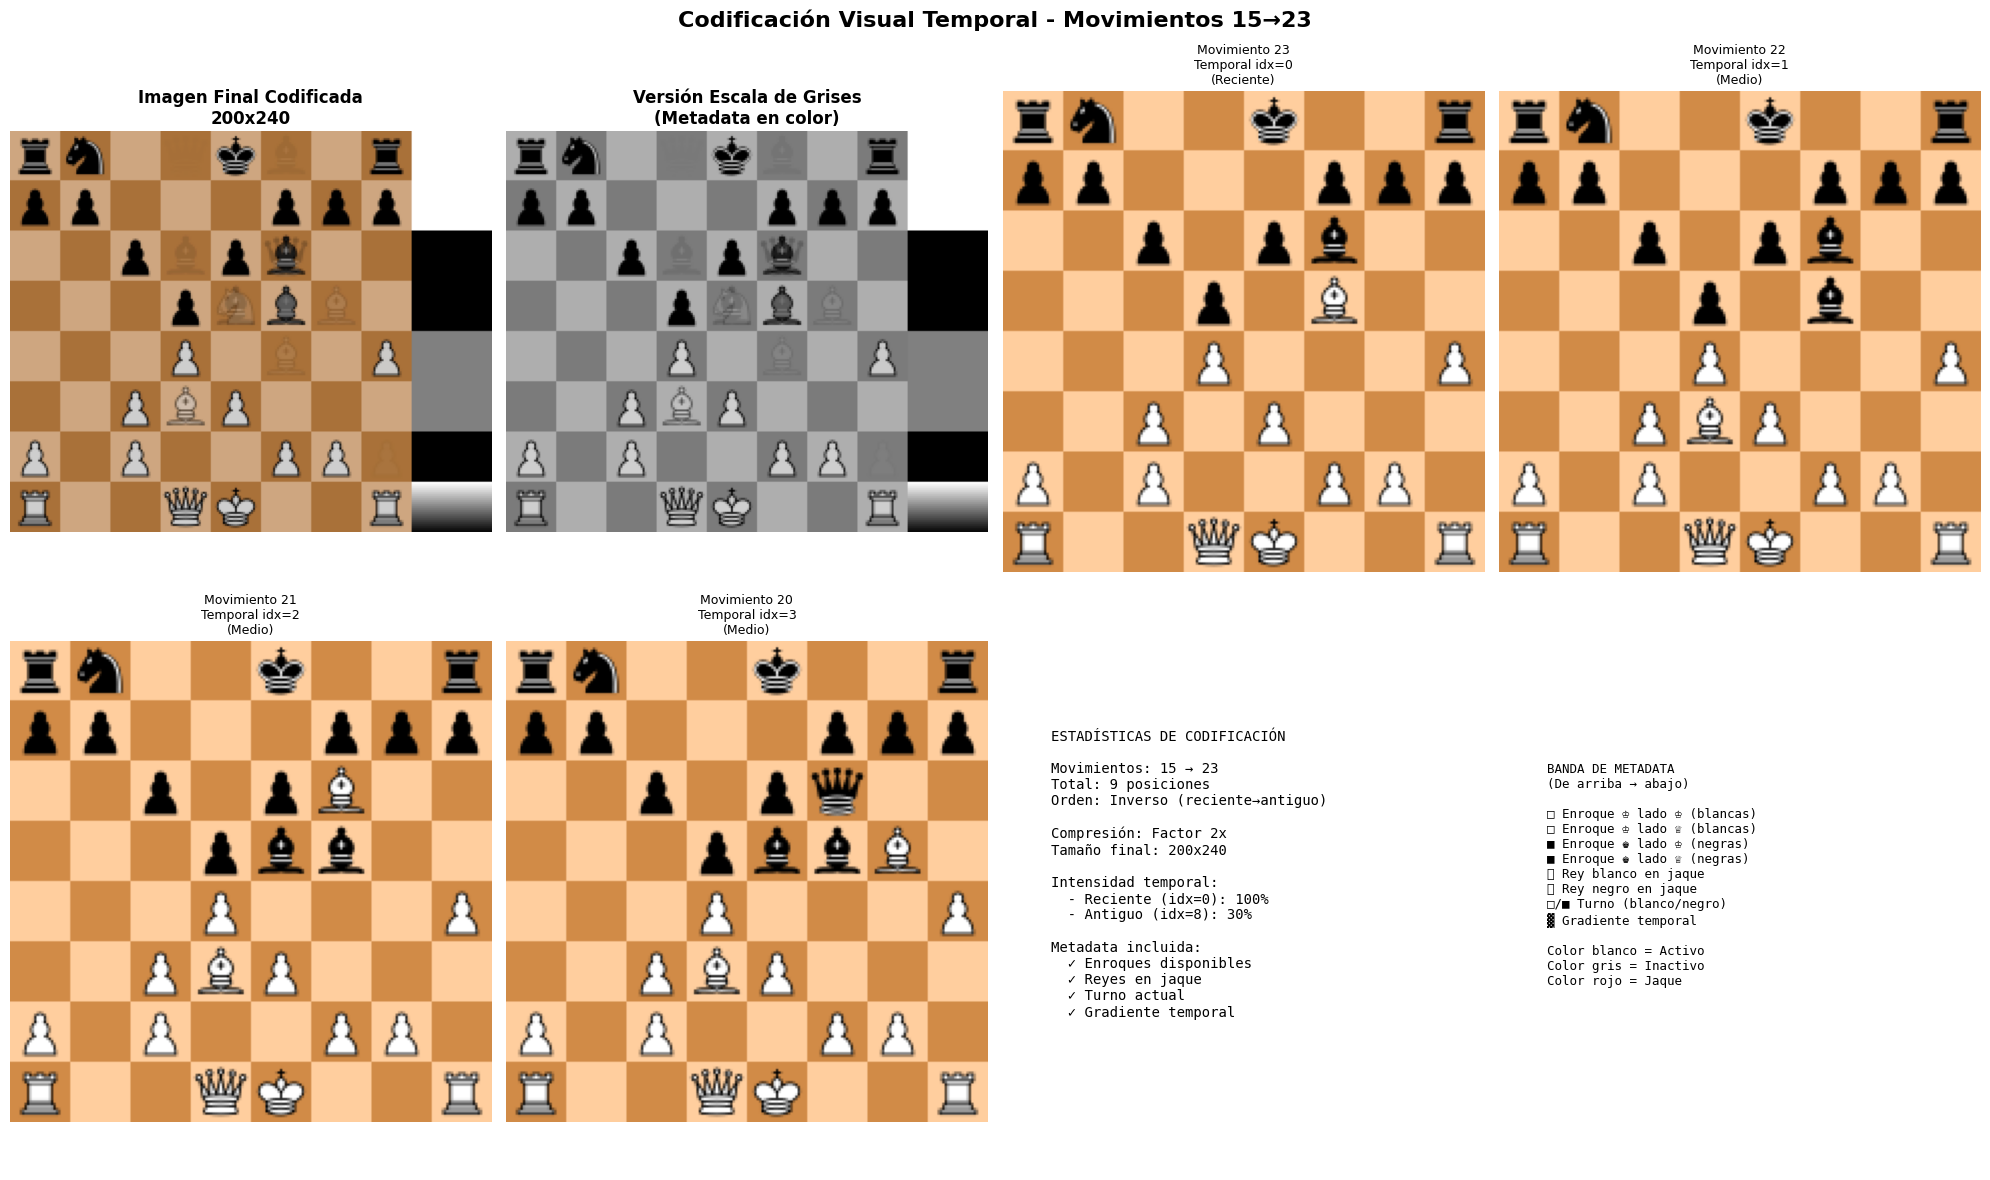


DETALLES DE LA CODIFICACIÓN TEMPORAL
Secuencia: Movimientos 15 a 23 (9 posiciones)
Orden procesamiento: INVERSO (más reciente primero)

Tamaño imagen final: (200, 240, 3)
Factor compresión: 2x
Memoria: 140.62 KB

Piezas visualmente reconocibles: SÍ

[4/4] Guardando imagen...
      ✓ Guardado: chess_visual_temporal_c2_m15-23.png
      ✓ Guardado (escala de grises): chess_visual_temporal_gray_c2_m15-23.png

✅ PROCESO COMPLETADO


In [21]:
# Pipeline completo
print("="*70)
print("GENERANDO CODIFICACIÓN VISUAL TEMPORAL")
print("="*70)
print(f"\nMovimientos: {START_MOVE} → {END_MOVE} (orden inverso en procesamiento)")
print(f"Factor de compresión: {COMPRESSION_FACTOR}x")
print(f"Intensidad: {MIN_INTENSITY*100:.0f}% (antiguo) a {MAX_INTENSITY*100:.0f}% (reciente)")
print(f"Banda de metadata: {METADATA_BAND_WIDTH}px\n")

# Paso 1: Extraer secuencia de tableros
print("[1/4] Extrayendo secuencia de tableros desde PGN...")
board_sequence = extract_board_sequence(
    PGN_TEXT,
    START_MOVE,
    END_MOVE,
    BOARD_SIZE_PIXELS
)
print(f"      ✓ Extraídos {len(board_sequence)} tableros")
print(f"      ✓ Orden: Movimiento {board_sequence[0]['move_number']} (reciente) → "
      f"Movimiento {board_sequence[-1]['move_number']} (antiguo)")

# Paso 2: Superponer con intensidad temporal
print("\n[2/4] Superponiendo tableros con intensidad temporal...")
temporal_image = overlay_temporal_sequence(
    board_sequence,
    compression_factor=COMPRESSION_FACTOR,
    min_intensity=MIN_INTENSITY,
    max_intensity=MAX_INTENSITY,
    add_metadata_band=True,
    metadata_band_width=METADATA_BAND_WIDTH
)
print(f"      ✓ Imagen temporal generada: {temporal_image.shape}")

# Paso 3: Visualizar
print("\n[3/4] Generando visualización...")
visualize_temporal_encoding(
    temporal_image,
    board_sequence,
    COMPRESSION_FACTOR,
    START_MOVE,
    END_MOVE
)

# Paso 4: Guardar
print("[4/4] Guardando imagen...")
output_filename = f'chess_visual_temporal_c{COMPRESSION_FACTOR}_m{START_MOVE}-{END_MOVE}.png'
cv2.imwrite(output_filename, cv2.cvtColor(temporal_image, cv2.COLOR_RGB2BGR))
print(f"      ✓ Guardado: {output_filename}")

# Versión en escala de grises
grayscale_version = convert_to_grayscale_temporal(temporal_image, 
                                                  preserve_metadata=True,
                                                  metadata_band_width=METADATA_BAND_WIDTH)
gray_filename = f'chess_visual_temporal_gray_c{COMPRESSION_FACTOR}_m{START_MOVE}-{END_MOVE}.png'
cv2.imwrite(gray_filename, cv2.cvtColor(grayscale_version, cv2.COLOR_RGB2BGR))
print(f"      ✓ Guardado (escala de grises): {gray_filename}")

print("\n" + "="*70)
print("✅ PROCESO COMPLETADO")
print("="*70)

In [23]:
# Comparativa de factores de compresión
print("\n" + "="*70)
print("COMPARATIVA DE FACTORES DE COMPRESIÓN")
print("="*70 + "\n")

for factor in [1, 2, 4, 8]:
    try:
        img = overlay_temporal_sequence(
            board_sequence,
            compression_factor=factor,
            min_intensity=MIN_INTENSITY,
            max_intensity=MAX_INTENSITY,
            add_metadata_band=False  # Sin banda para comparación pura
        )
        
        original_size = BOARD_SIZE_PIXELS
        compressed_size = original_size // factor
        reduction = (1 - (compressed_size / original_size) ** 2) * 100
        recognizable = "SÍ" if factor <= 2 else "PARCIAL" if factor <= 4 else "NO"
        
        print(f"Factor {factor}x:")
        print(f"  Tamaño: {img.shape[0]}x{img.shape[1]}")
        print(f"  Reducción área: {reduction:.1f}%")
        print(f"  Memoria: {img.nbytes / 1024:.2f} KB")
        print(f"  Piezas reconocibles: {recognizable}")
        print()
        
    except Exception as e:
        print(f"Factor {factor}x: ERROR - {str(e)}\n")

print("="*70)


COMPARATIVA DE FACTORES DE COMPRESIÓN

Factor 1x:
  Tamaño: 400x400
  Reducción área: 0.0%
  Memoria: 468.75 KB
  Piezas reconocibles: SÍ

Factor 2x:
  Tamaño: 200x200
  Reducción área: 75.0%
  Memoria: 117.19 KB
  Piezas reconocibles: SÍ

Factor 4x:
  Tamaño: 100x100
  Reducción área: 93.8%
  Memoria: 29.30 KB
  Piezas reconocibles: PARCIAL

Factor 8x:
  Tamaño: 50x50
  Reducción área: 98.4%
  Memoria: 7.32 KB
  Piezas reconocibles: NO



## Notas de implementación

### Diferencias clave vs. versión 2.0

1. **Piezas visualmente reconocibles**:
   - Se renderizan tableros completos como SVG → PNG
   - La CNN puede "ver" las piezas directamente
   - No se usa abstracción numérica de piezas

2. **Orden temporal invertido**:
   - Posición 0 = movimiento MÁS RECIENTE
   - Última posición = movimiento MÁS ANTIGUO
   - Facilita el aprendizaje (lo importante está primero)

3. **Intensidad temporal por multiplicación**:
   - Movimientos antiguos se oscurecen (×0.3)
   - Movimientos recientes mantienen brillo (×1.0)
   - Gradiente suave entre ambos extremos

4. **Banda de metadata visual**:
   - Codifica estado del juego visualmente
   - Enroques, jaques, turno, gradiente temporal
   - 40px de ancho, 8 secciones verticales

5. **Compresión controlada**:
   - Factor 1-2: Piezas claramente reconocibles
   - Factor 4: Piezas reconocibles pero pixeladas
   - Factor 8: Límite de reconocimiento visual

### Ventajas para CNNs

- **Interpretación directa**: La red "ve" el tablero como un humano
- **Transfer learning**: Puede aprovechar CNNs preentrenadas en ImageNet
- **Información temporal**: Intensidad indica antigüedad del movimiento
- **Metadata integrada**: Estado del juego en la misma imagen
- **Flexible**: Funciona en color o escala de grises

### Casos de uso

| Tarea | Factor recomendado | Color/Gris | Metadata |
|-------|-------------------|------------|----------|
| Evaluación de posición | 1-2 | Color | Sí |
| Predicción de movimiento | 1 | Color | Sí |
| Detección de tácticas | 2 | Color | No |
| Clasificación de estilo | 2-4 | Gris | Sí |
| Reconocimiento de patrones | 4 | Gris | No |